Extract samples of gambiae and coluzzii from sequencing dataset used in Sample ID, align and convert to zarr genotype calls relative to PEST genome. Also subset to Ag1000g biallelic positions.

Results:
- sequences converted to genotype calls & nalts, subsetted and visualised
- lots of variants are lost with subsetting to Ag1000g biallelic sites. These mostly come from large inaccessible regions, but novel variants in sequencing are quite common as well.



Limitations: 
- not accounting for various ALTs - all substitutions get 1, all deletions get -1 (missing), insertions are ignored.
- ignoring multiallelic calls
- manual POS margin adjustment to fit with Ag1000g records 

TODO: - in future conversions, check REF/ALT for a) ALT recoding b) POS consistenct checks

In [1]:
import os
import sys
import zarr
import allel
import numpy as np
import pandas as pd
from Bio import AlignIO
import matplotlib.pyplot as plt

In [2]:
#in
# sequencing data and metadata used for Species ID
SEQ_FILE = '../7_species_id/data/0_haplotypes.csv'
SEQ_META_FILE = '../7_species_id/data/0_samples.csv'
# reference data and metadata
REF_FILE = '../4_ref_extraction/data/refs.csv'
REF_META_FILE = '../4_ref_extraction/data/samples_ref.csv'
# panel metadata - for positions
PANEL = '../../data/panel_info.csv'


# out
WD = '../../../data/phylo_ampl_ag1k/seq_samples'
ALN_FA = os.path.join(WD, '{}.fa')
ZARR = os.path.join(WD, 'seq_samples.zarr')
SPP_META = (os.path.join(WD, 'seq_samples.meta.csv'))
# ag1000g zarr for positions extraction
AG1K_ZARR = os.path.join(WD, '../phase2/AR1')
AG1K_META = os.path.join(WD, '../phase2/AR1/samples/samples.meta.txt')

# params
# species to extract
SPP = ['Anopheles_gambiae','Anopheles_coluzzii']
# amplicons
AMPLS = [str(i) for i in range(62)]
# reference genome sample name - used as REF allele state
REF_SAMPLE = 'anopheles-gambiae-pestchromosomesagamp4'

In [3]:
! mkdir -p {WD}

In [4]:
panel = pd.read_csv(PANEL, index_col='amplicon')
panel.head()

,chrom,start,end,F,R,conc_multiplier,aligned_ampl_length,agam_ampl_length,aligned_insert_length,agam_insert_length,exon,gene,intron,mRNA,repeat,utr,aligned_in_outgroup,start_insert,end_insert
amplicon,,,,,,,,,,,,,,,,,,,
0,2L,10356417,10356608,TGTSTACGGTCTGAAGAACATc,TTATCCGGCTCCAAGTTAAGG,10.0,259,191.0,216.0,148.0,E016098A;E016099A,AGAP005134,Yes,AGAP005134-RA,None,None,No,10356439,10356587
1,2L,10357458,10357648,GAGCGtGCGGCcAAGATG,ACAgACCGACGTTAATGGC,10.0,190,190.0,153.0,153.0,E016100A,AGAP005134,None,AGAP005134-RA,None,None,Yes,10357476,10357629
2,2L,12084495,12084690,CAGTCAAATTTCCAGACAATCT,CGGAAGTGCATTTGAAGGAAaA,5.8,234,195.0,190.0,152.0,None,None,None,None,None,None,NaN,12084517,12084668
3,2L,13862864,13863055,GaTATAAATTGTCGATCACACAAACT,TGCATTTATCGTAGTACAATCTCA,2.6,255,191.0,205.0,141.0,None,None,None,None,None,None,NaN,13862890,13863031
4,2L,18693481,18693714,ATGcTBGTCATgATGATGATCT,CCGATCCACGATAAGGAGTAC,10.0,270,233.0,227.0,190.0,E018545A,AGAP005681,None,AGAP005681-RA,None,None,Yes,18693503,18693693


## Read and combine sequencing and reference data

In [5]:
all_seq = pd.read_csv(SEQ_FILE, dtype=str)
all_meta = pd.read_csv(SEQ_META_FILE, dtype=str)

In [6]:
all_ref_seq = pd.read_csv(REF_FILE, dtype=str)
all_ref_meta = pd.read_csv(REF_META_FILE, dtype=str)

In [7]:
comb_seq = pd.concat([all_seq, all_ref_seq], sort=False)
comb_seq.head(1)

,s_Sample,target,consensus,reads
0,Abro-21,13,TCTCCATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATG...,23


In [8]:
comb_meta = pd.concat([all_meta, all_ref_meta], sort=False)
comb_meta.head(1)

,s_Sample,External ID,Date of Collection,Location,Country,Latitude,Longitude,Species,Collection Context,Collection Method,Collection Time,Specimen Sex,Specimen Type,Extraction Method,Sample type,Sample Set,Sample Type,Source
0,Amou-2-1,2.1,2017-06-29,Bakoumba,Gabon,-1.82201,13.00286,Anopheles_moucheti,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,CTAB,Genomic DNA,ga,NaN,run1


## Subset to species of interest

In [9]:
spp_meta = comb_meta[comb_meta.Species.isin(SPP)].copy()
spp_meta

,s_Sample,External ID,Date of Collection,Location,Country,Latitude,Longitude,Species,Collection Context,Collection Method,Collection Time,Specimen Sex,Specimen Type,Extraction Method,Sample type,Sample Set,Sample Type,Source
53,Acol-558,558,2016-05-02,Lopé,Gabon,-0.19124,11.59327,Anopheles_coluzzii,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,QIAGEN,Genomic DNA,ga,NaN,run1
54,Acol-570,570,2016-05-02,Lopé,Gabon,-0.19124,11.59327,Anopheles_coluzzii,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,QIAGEN,Genomic DNA,ga,NaN,run1
55,Acol-645,645,2016-07-02,Lopé,Gabon,-0.19124,11.59327,Anopheles_coluzzii,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,QIAGEN,Genomic DNA,ga,NaN,run1
79,Agam-30,30,2017-01-19,Benguia,Gabon,-1.63281,13.49217,Anopheles_gambiae,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,CTAB,Genomic DNA,ga,NaN,run2
80,Agam-32,32,2017-01-19,Benguia,Gabon,-1.63281,13.49217,Anopheles_gambiae,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,CTAB,Genomic DNA,ga,NaN,run2
81,Agam-35,35,2017-01-19,Benguia,Gabon,-1.63281,13.49217,Anopheles_gambiae,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,CTAB,Genomic DNA,ga,NaN,run2
82,Agam-37,37,2017-01-19,Benguia,Gabon,-1.63281,13.49217,Anopheles_gambiae,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,CTAB,Genomic DNA,ga,NaN,run2
83,Agam-38,38,2017-01-19,Benguia,Gabon,-1.63281,13.49217,Anopheles_gambiae,Outdoors,Human Landing Catch,NaN,Female,Wild caught adult,CTAB,Genomic DNA,ga,NaN,run2
6,anopheles-coluzzii-mali-nihscaffoldsacolm1,NaN,NaN,NaN,NaN,NaN,NaN,Anopheles_coluzzii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ref,NaN,ref
15,anopheles-gambiae-pestchromosomesagamp4,NaN,NaN,NaN,NaN,NaN,NaN,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ref,NaN,ref


In [10]:
spp_seq = comb_seq[comb_seq.s_Sample.isin(spp_meta.s_Sample)].copy()
spp_seq.shape

(841, 4)

In [11]:
# assign IDs to unique sequences
combuids = dict()
for tgt, group in spp_seq.groupby(['target']):
    for (i, cons) in enumerate(group['consensus'].unique()):
        combuids[tgt+cons] = '{}-{}'.format(tgt, i)
spp_seq['combUID'] = (spp_seq.target + spp_seq.consensus).replace(combuids)
spp_seq.sample(3)

,s_Sample,target,consensus,reads,combUID
4694,Agam-32,49,AACGGCGATGCAATTTCCAATCCCTGCCCGCCAATTCTCCAAAACC...,506,49-2
4942,Agam-38,42,AAAACTGCCACAGGAAAAAGCGGGACACACGGACCGAGGGCCCGTC...,112,42-11
292,Acol-558,6,GGAGCGCATCAATGGCACCATCAGCCCGACGGTAAAAGCCACTGCA...,19,6-0


## Ag1k compatible metadata

In [12]:
spp_meta.rename(
    {'s_Sample':'ox_code',
     'Source':'population',
     'Country':'country',
     'Specimen Sex':'sex'},
    axis=1,
    inplace=True)
# population labels
spp_meta['pop_label'] = spp_meta.population.replace(pop_labels)
spp_meta['m_s'] = spp_meta.Species.replace(
    {'Anopheles_gambiae':'S',
     'Anopheles_coluzzii':'M'})
spp_meta = spp_meta[['ox_code','country','population','sex','m_s','pop_label']]
spp_meta.head()

,ox_code,country,population,sex,m_s,pop_label
53,Acol-558,Gabon,run1,Female,M,ANO_SPP Gabon $coluzzii$
54,Acol-570,Gabon,run1,Female,M,ANO_SPP Gabon $coluzzii$
55,Acol-645,Gabon,run1,Female,M,ANO_SPP Gabon $coluzzii$
79,Agam-30,Gabon,run2,Female,S,ANO_SPP Gabon $gambiae$
80,Agam-32,Gabon,run2,Female,S,ANO_SPP Gabon $gambiae$


In [13]:
# write meta
spp_meta.to_csv(SPP_META, index=False)
! head -2 {SPP_META}

ox_code,country,population,sex,m_s,pop_label
Acol-558,Gabon,run1,Female,M,ANO_SPP Gabon $coluzzii$


## Align each amplicon

In [14]:
# generate alignments
for ampl in AMPLS:
    sys.stdout.write('\r' + ampl)
    out_fa = ALN_FA.format(ampl)
    # do not re-generate existing alignments
    if os.path.isfile(out_fa):
        continue
    # subset amplicon data
    ampl_data = spp_seq[spp_seq.target == ampl]
    # get only unique sequences
    ampl_data = ampl_data[~ampl_data.combUID.duplicated()]
    # write under combUID name
    with open('temp.fa', 'w') as o:
        for (i, row) in ampl_data.iterrows():
            o.write('>{}\n{}\n'.format(row.combUID,
                                       row.consensus))
    # align
    ! mafft temp.fa > {out_fa} 2> /dev/null
    ! rm temp.fa
print('\nDone!')

61
Done!


In [15]:
# add alignments to sequence table
aln_dict = {}
for ampl in AMPLS:
    aln = AlignIO.read(ALN_FA.format(ampl), 'fasta')
    ampl_aln_dict = {seq.name:str(seq.seq) for seq in aln}
    aln_dict.update(ampl_aln_dict)
spp_seq['aln'] = spp_seq.combUID.replace(aln_dict)
spp_seq.sample(3)

,s_Sample,target,consensus,reads,combUID,aln
260,Acol-558,38,TTAAATCGTGCCTGGTGTGCCGTGCGCTAGGTGCTAAAGATGGAAC...,27,38-0,ttaaatcgtgcctggtgtgccgtgcgctaggtgctaaagatggaac...
4827,Agam-37,26,TAAAATGTTGCTCGCAAAACGGGGGCCCTCGGAATGAGCGGGAACG...,190,26-6,taaaatgttgctcgcaaaacgggggccctcggaatgagcgggaacg...
389,Acol-645,17,GGTCTAGACCCGGAAGCCCTCACCGGCAAGTACCCGGTAAGTGTTG...,39,17-6,ggtctagacccggaagccctcaccggcaagtacccggtaagtgttg...


## Covert, subset & store

In [16]:
def call_haploid(seq, ref_seq):
    '''
    Simple genotype inference relative to reference:
    match - 0,
    mismatch - 1
    indel - -1
    
    Not vectorised
    
    Not accounting for various ALT's
    '''
    assert len(seq) == len(ref_seq), 'sequences unaligned'
    
    gt = []
    
    for c, ref_c in zip(seq, ref_seq):
        # skip insertions
        if ref_c == '-':
            continue
        # deletion - missing data
        if c == '-':
            gt.append(-1)
        # match
        elif c == ref_c:
            gt.append(0)
        # mismatch
        else:
            gt.append(1)
    return gt
    
call_haploid('a-tt','ac-c')

[0, -1, 1]

In [17]:
# mandatory pre-clean
! rm -r {ZARR}

for ampl in AMPLS:
    sys.stdout.write('\r' + ampl)
    # amplicon sequence data
    ampl_seq = spp_seq[spp_seq.target == ampl].copy()
    # reference alignment
    ampl_ref_aln = ampl_seq.loc[ampl_seq.s_Sample == REF_SAMPLE, 'aln']
    assert ampl_ref_aln.shape[0] == 1, 'non-unique or missing REF seq in {}'.format(ampl)
    ampl_ref_aln = ampl_ref_aln.iloc[0]
    # gapless ref length
    ampl_ref_len = len(ampl_ref_aln.replace('-',''))
    
    # convert haploid genotypes
    ampl_seq['gt'] = ampl_seq.aln.apply(lambda x: call_haploid(x, ampl_ref_aln))
    
    # diploid sample genotypes
    # output gt matrix axes samples:sites:ploidy
    ampl_gt = []
    # order of samples as in metadata
    for sample in spp_meta.ox_code:
        sample_ampl_gt = ampl_seq.loc[ampl_seq.s_Sample == sample, 'gt']
        # missing
        if sample_ampl_gt.shape[0] == 0:
            diploid_gt = [(-1,-1) for i in range(ampl_ref_len)]
        # homozygous
        elif sample_ampl_gt.shape[0] == 1:
            diploid_gt = [(x,x) for x in sample_ampl_gt.iloc[0]]
        # heterozygous - take first two alleles
        else:
            diploid_gt = [(x,y) for x,y in zip(sample_ampl_gt.iloc[0], sample_ampl_gt.iloc[1])]
            if sample_ampl_gt.shape[0] > 2:
                print('Warning: more than two alleles in sample {} amplicon {}'.format(sample, ampl))
        ampl_gt.append(diploid_gt)
    # reshape to sites:samples:ploidy
    ampl_gt = np.swapaxes(ampl_gt, 0, 1)
    
    # get amplicon coordinates in PEST 
    # NB corrected to be compatible with Ag1k coordinates
    ampl_pos = np.arange(panel.loc[ampl,'start_insert'] + 1, panel.loc[ampl,'end_insert'] + 1)
    
    # get positions of ag1k biallelic sites
    ag_root = zarr.open_group(AG1K_ZARR, "r")
    ag_ampl_pos = ag_root[ampl]['POS'][:]
    
    # mask sequenced sample positions
    mask = np.in1d(ampl_pos, ag_ampl_pos)
    # subset along axis 0 (variants)
    agpos_ampl_gt = ampl_gt[mask,:,:]
    assert ag_ampl_pos.shape[0] == agpos_ampl_gt.shape[0], 'Position subsetting failed in {}'.format(ampl)
    
    # compute nalts
    agpos_ampl_nalt = allel.GenotypeArray(agpos_ampl_gt).to_n_alt()
    
    # write
    root = zarr.open_group(ZARR, "a")
    g = root.create_group(ampl)
    g.create_dataset('genotype', data=agpos_ampl_gt)
    g.create_dataset('NALT', data=agpos_ampl_nalt)

    ampl_nalt = allel.GenotypeArray(ampl_gt).to_n_alt()
    g.create_dataset('raw_genotype', data=ampl_gt)
    g.create_dataset('raw_nalt', data=ampl_nalt)
    
print('\nDone!')

61
Done!


## Plot variant/invariant sites

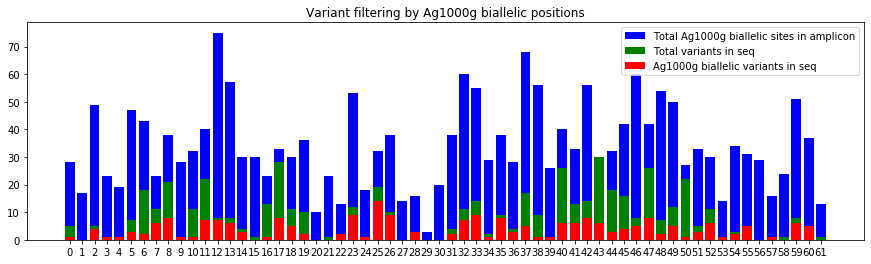

In [18]:
root = zarr.open_group(ZARR, "r")
fig, ax = plt.subplots(1,1, figsize=(15,4))
# how many variants in each amplicon?
for ampl in AMPLS:
    raw_isvar = np.any((root[ampl]['raw_nalt'][:] > 0), axis=1) # not considering all ALT - PEST is all REF
    isvar = np.any((root[ampl]['NALT'][:] > 0), axis=1) # not considering all ALT - PEST is all REF
    p0 = ax.bar(ampl, isvar.shape[0], color='b')
    p1 = ax.bar(ampl, raw_isvar.sum(), color='g')
    p2 = ax.bar(ampl, isvar.sum(), color='r')
    plt.legend((p0[0], p1[0], p2[0], ), 
               ('Total Ag1000g biallelic sites in amplicon',
                'Total variants in seq', 
                'Ag1000g biallelic variants in seq',))
ax.set_title('Variant filtering by Ag1000g biallelic positions');

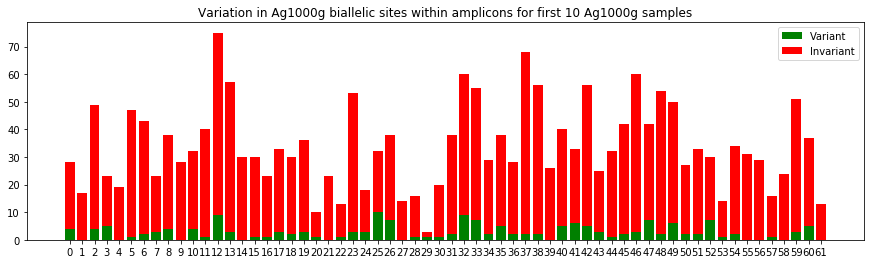

In [19]:
# compare to selection of samples samples of ag1k
root = zarr.open_group(AG1K_ZARR, "r")
fig, ax = plt.subplots(1,1, figsize=(15,4))
# how many variants in each amplicon?
for ampl in AMPLS:
    sampleset = slice(953,962)
    isvar = np.any((root[ampl]['NALT'][:, sampleset] > 0), axis=1) # not considering all ALT - PEST is all REF
    p1 = ax.bar(ampl, isvar.sum(), color='g')
    p2 = ax.bar(ampl, (~isvar).sum(), bottom=isvar.sum(), color='r')
    plt.legend((p1[0], p2[0]), ('Variant', 'Invariant'))
ax.set_title('Variation in Ag1000g biallelic sites within amplicons for first 10 Ag1000g samples');

In [20]:
raise Exception('Analysis ended!')

Exception: Analysis ended!

## Variant filtering sandbox

In [21]:
ag1k_meta = pd.read_csv(AG1K_META, sep='\t')


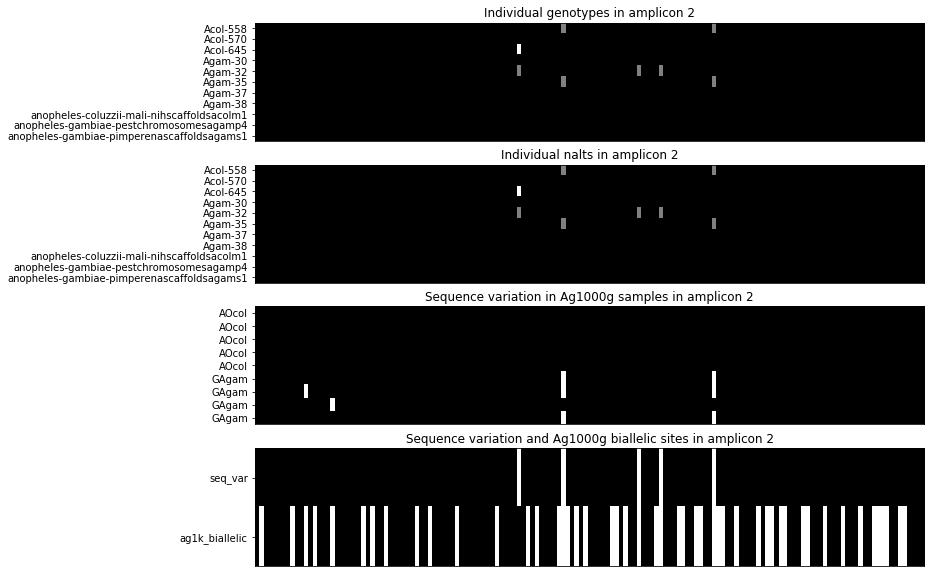

In [22]:
# visualise sequencing variants and ag1k biallelic sites for a given amplicon
# data
def plot_ampl_var_pattern(ampl):
    # seq data
    seq_root = zarr.open_group(ZARR, "r")
    # mask
    raw_isvar = np.any((seq_root[ampl]['raw_nalt'][:] > 0), axis=1)
    # individual variants
    ind_var = np.sum(seq_root[ampl]['raw_genotype'][:], axis=2)
    ind_var = np.swapaxes(ind_var, 0,1)
    # individual nsites
    ind_nalt = seq_root[ampl]['raw_nalt']
    ind_nalt = np.swapaxes(ind_nalt, 0,1)
    seq_len = ind_var.shape[1]
    # ref data
    ag_root = zarr.open_group(AG1K_ZARR, "r")
    # coordinate corrected to match POS in Ag1000g
    ampl_pos = np.arange(panel.loc[ampl,'start_insert'] + 1, panel.loc[ampl,'end_insert'] + 1)
    ag_ampl_pos = ag_root[ampl]['POS'][:]
    ag_ampl_pos_mask = np.in1d(ampl_pos, ag_ampl_pos)
    # sample 5 AOcol and GAgam
    sampleset = slice(953,962)
    ags_nalt = ag_root[ampl]['NALT'][:,sampleset]
    ags_nalt = np.swapaxes(ags_nalt, 0,1)
    # expand to sequence length (fill with REF)
    large_ags_nalt = np.zeros([ags_nalt.shape[0],seq_len])
    large_ags_nalt[:, ag_ampl_pos_mask] = ags_nalt
    # comb data
    d = [raw_isvar,ag_ampl_pos_mask]
    # plot
    fig_w = seq_len // 12
    fig, axs = plt.subplots(4,1,figsize=(fig_w,10))
    # ind var
    axs[0].imshow(ind_var, aspect='auto', cmap=plt.cm.gray);
    axs[0].set_yticks(range(ind_var.shape[0]))
    axs[0].set_yticklabels(spp_meta.ox_code)
    axs[0].set_title('Individual genotypes in amplicon {}'.format(ampl))
    axs[0].set_xticks([])
    # ind nalt
    axs[1].imshow(ind_nalt, aspect='auto', cmap=plt.cm.gray);
    axs[1].set_yticks(range(ind_var.shape[0]))
    axs[1].set_yticklabels(spp_meta.ox_code)
    axs[1].set_title('Individual nalts in amplicon {}'.format(ampl))
    axs[1].set_xticks([])
    # masks
    axs[3].imshow(d, aspect='auto', cmap=plt.cm.gray);
    axs[3].set_yticks(range(len(d)))
    axs[3].set_yticklabels(['seq_var','ag1k_biallelic'])
    axs[3].set_title('Sequence variation and Ag1000g biallelic sites in amplicon {}'.format(ampl))
    axs[3].set_xticks([])
    # ag1k variation 
    axs[2].imshow(large_ags_nalt, aspect='auto', cmap=plt.cm.gray)
    axs[2].set_yticks(range(ags_nalt.shape[0]))
    axs[2].set_yticklabels(ag1k_meta.loc[sampleset, 'population'])
    axs[2].set_title('Sequence variation in Ag1000g samples in amplicon {}'.format(ampl))
    axs[2].set_xticks([])
plot_ampl_var_pattern('2')

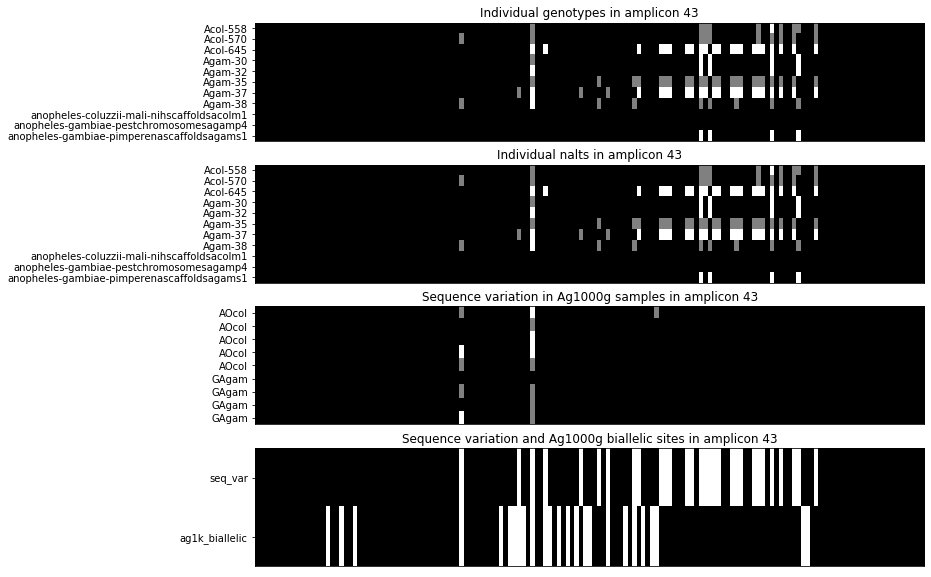

In [23]:
plot_ampl_var_pattern('43')

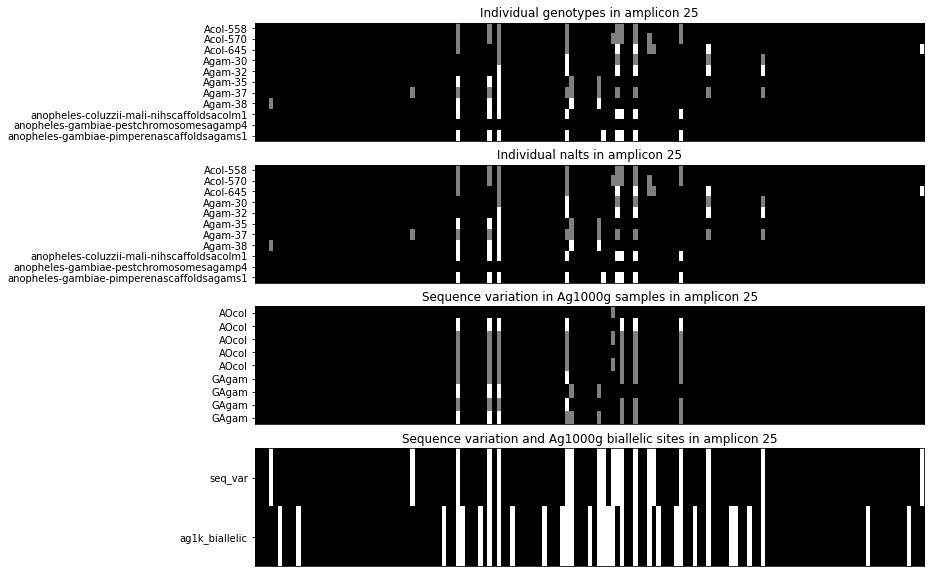

In [24]:
plot_ampl_var_pattern('25')

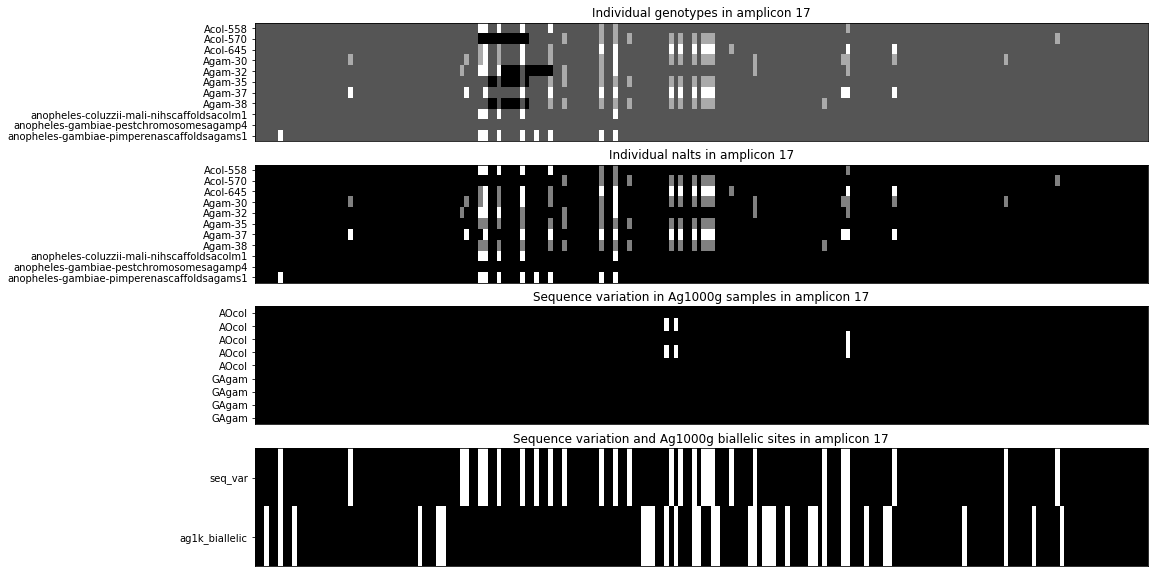

In [25]:
plot_ampl_var_pattern('17')

## Convert to zarr sandbox

In [ ]:
! rm -r {ZARR}

In [ ]:
ampl = '6'

In [ ]:
ampl_seq = spp_seq[spp_seq.target == ampl].copy()
ampl_seq

In [ ]:
ampl_ref_aln = ampl_seq.loc[ampl_seq.s_Sample == REF_SAMPLE, 'aln']
assert ampl_ref_aln.shape[0] == 1, 'non-unique or missing REF seq in {}'.format(ampl)
ampl_ref_aln = ampl_ref_aln.iloc[0]
ampl_ref_aln

In [ ]:
# gapless ref length
ampl_ref_len = len(ampl_ref_aln.replace('-',''))
ampl_ref_len

In [ ]:
def call_haploid(seq, ref_seq):
    '''
    Simple genotype inference relative to reference:
    match - 0,
    mismatch - 1
    indel - -1
    
    Not vectorised
    
    Not accounting for various ALT's
    '''
    assert len(seq) == len(ref_seq), 'sequences unaligned'
    
    gt = []
    
    for c, ref_c in zip(seq, ref_seq):
        # skip insertions
        if ref_c == '-':
            continue
        # deletion - missing data
        if c == '-':
            gt.append(-1)
        # match
        elif c == ref_c:
            gt.append(0)
        # mismatch
        else:
            gt.append(1)
    return gt
    
call_haploid('a-tt','ac-c')

In [ ]:
ampl_seq['gt'] = ampl_seq.aln.apply(lambda x: call_haploid(x, ampl_ref_aln))
ampl_seq['gt'].apply(lambda x: sum(x))

In [ ]:
# output gt matrix axes samples:sites:ploidy
ampl_gt = []
# order of samples as in metadata
for sample in spp_meta.ox_code:
    sample_ampl_gt = ampl_seq.loc[ampl_seq.s_Sample == sample, 'gt']
    # missing
    if sample_ampl_gt.shape[0] == 0:
        diploid_gt = [(-1,-1) for i in range(ampl_ref_len)]
    # homozygous
    elif sample_ampl_gt.shape[0] == 1:
        diploid_gt = [(x,x) for x in sample_ampl_gt.iloc[0]]
    # heterozygous - take first two alleles
    else:
        diploid_gt = [(x,y) for x,y in zip(sample_ampl_gt.iloc[0], sample_ampl_gt.iloc[1])]
        if sample_ampl_gt.shape[0] > 2:
            print('Warning: more than two alleles in sample {} amplicon {}'.format(sample, ampl))
    ampl_gt.append(diploid_gt)
# reshape to sites:samples:ploidy
ampl_gt = np.swapaxes(ampl_gt, 0, 1)
ampl_gt.shape

In [ ]:
# get coordinates in PEST
ampl_pos = np.arange(panel.loc[ampl,'start_insert'], panel.loc[ampl,'end_insert'])
len(ampl_pos)

In [ ]:
ampl_pos

In [ ]:
# get positions used in ag1k
ag_root = zarr.open_group(AG1K_ZARR, "r")
ag_ampl_pos = ag_root[ampl]['POS'][:]
ag_ampl_pos

In [ ]:
ag_root[ampl].tree()

In [ ]:
# mask with positions in Ag1000g dataset
mask = np.in1d(ampl_pos, ag_ampl_pos)
# subset along axis 1 (variants)
ag_ampl_gt = ampl_gt[mask,:,:]
assert ag_ampl_pos.shape[0] == ag_ampl_gt.shape[0], 'Position subsetting failed in {}'.format(ampl)

In [ ]:
# nalts
ag_ampl_nalt = allel.GenotypeArray(ag_ampl_gt).to_n_alt()

In [ ]:
ag_ampl_nalt.shape

In [ ]:
# write
root = zarr.open_group(ZARR, "a")
g = root.create_group(ampl)
g.create_dataset('genotype', data=ag_ampl_gt)
g.create_dataset('NALT', data=ag_ampl_nalt)